In [25]:
%matplotlib inline
import xarray as xr
import numpy as np
from time import time
import pickle
import statsmodels.api as sm

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Myriad Pro'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

path_ = '/home/mizu_home/xp53/nas/BEST/TAVG/'
pre_ = 'Complete_TAVG_Daily_LatLong1_'

from ipcc_colormap import *
cmap_prep = ipcc_cmap()
cmap_prep.read_rgb_data_from_excel()
;

''

In [6]:
# a hack from stackoverflow to normalize the colorbar and set arbitrary midpoint locations
# while maintaining the colorbar's linearity
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

In [2]:
# this is from gpt
# class MidpointNormalize(mpl.colors.Normalize):
#     def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
#         self.midpoint = midpoint
#         super().__init__(vmin, vmax, clip)
    
#     def __call__(self, value, clip=None):
#         result, is_scalar = self.process_value(value)
#         self.autoscale_None(result)
#         vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint
#         if not self.scaled():
#             return np.ma.masked_array(np.interp(result, [vmin, midpoint, vmax], [0, 0.5, 1]), mask=np.ma.getmask(result))
#         return np.ma.masked_array(np.interp(result, [vmin, midpoint, vmax], [0, 0.5, 1]), mask=np.ma.getmask(result))

In [ ]:

months = [1, 2, 3, 11, 12]
years = np.arange(1980, 2020, 10)
data = []
for yy in years:
    file_ = path_ + pre_ + str(yy) + '.nc'
    with xr.open_dataset(file_) as ds:
        t1 = time()
        for dy in range(10):
            for mm in months:
                if mm == 2:
                    filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm) & (ds.day != 29), drop=True)
                else:
                    filter_ds = ds.where((ds.latitude > 0) & (ds.year == yy + dy) & (ds.month == mm), drop=True)
                data.append(filter_ds.temperature)
        print('Time taken for year ', yy, ' is ', time() - t1)
    
concatenated_data = xr.concat(data, dim='time')
temp = concatenated_data.values
output = open('NH_winter_temp.pkl', 'wb')
pickle.dump(temp, output)
output.close()



In [3]:
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

temp_mean = np.zeros((39, 90, 360))
temp_median = np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    tmean = np.mean(temp[left:right, :, :], axis=0)
    tmedian = np.median(temp[left:right, :, :], axis=0)
    temp_mean[yy, :, :] = tmean
    temp_median[yy, :, :] = tmedian

mask = 1 - np.isnan(np.mean(temp_mean, axis=0))

In [4]:
k_mean = np.zeros((90, 360))
k_median = np.zeros((90, 360))
pv_mean = np.zeros((90, 360))
pv_median = np.zeros((90, 360))

xx = np.arange(39)
xx = sm.add_constant(xx)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm1 = sm.OLS(temp_mean[:, i, j], xx).fit()
        k_mean[i, j] = lm1.params[1] * 10 # multiply by 10 to get the trend per decade
        pv_mean[i, j] = lm1.pvalues[1]

        lm2 = sm.OLS(temp_median[:, i, j], xx).fit()
        k_median[i, j] = lm2.params[1] * 10
        pv_median[i, j] = lm2.pvalues[1]
        

Processing  1000  grids. Time taken so far:  1.0036334991455078
Processing  2000  grids. Time taken so far:  1.8545963764190674
Processing  3000  grids. Time taken so far:  2.636167287826538
Processing  4000  grids. Time taken so far:  3.4115188121795654
Processing  5000  grids. Time taken so far:  4.192052841186523
Processing  6000  grids. Time taken so far:  4.972257137298584
Processing  7000  grids. Time taken so far:  5.739943742752075
Processing  8000  grids. Time taken so far:  6.497033596038818
Processing  9000  grids. Time taken so far:  7.268583536148071
Processing  10000  grids. Time taken so far:  8.037270784378052
Processing  11000  grids. Time taken so far:  8.80672287940979
Processing  12000  grids. Time taken so far:  9.577851295471191
Processing  13000  grids. Time taken so far:  10.348210573196411


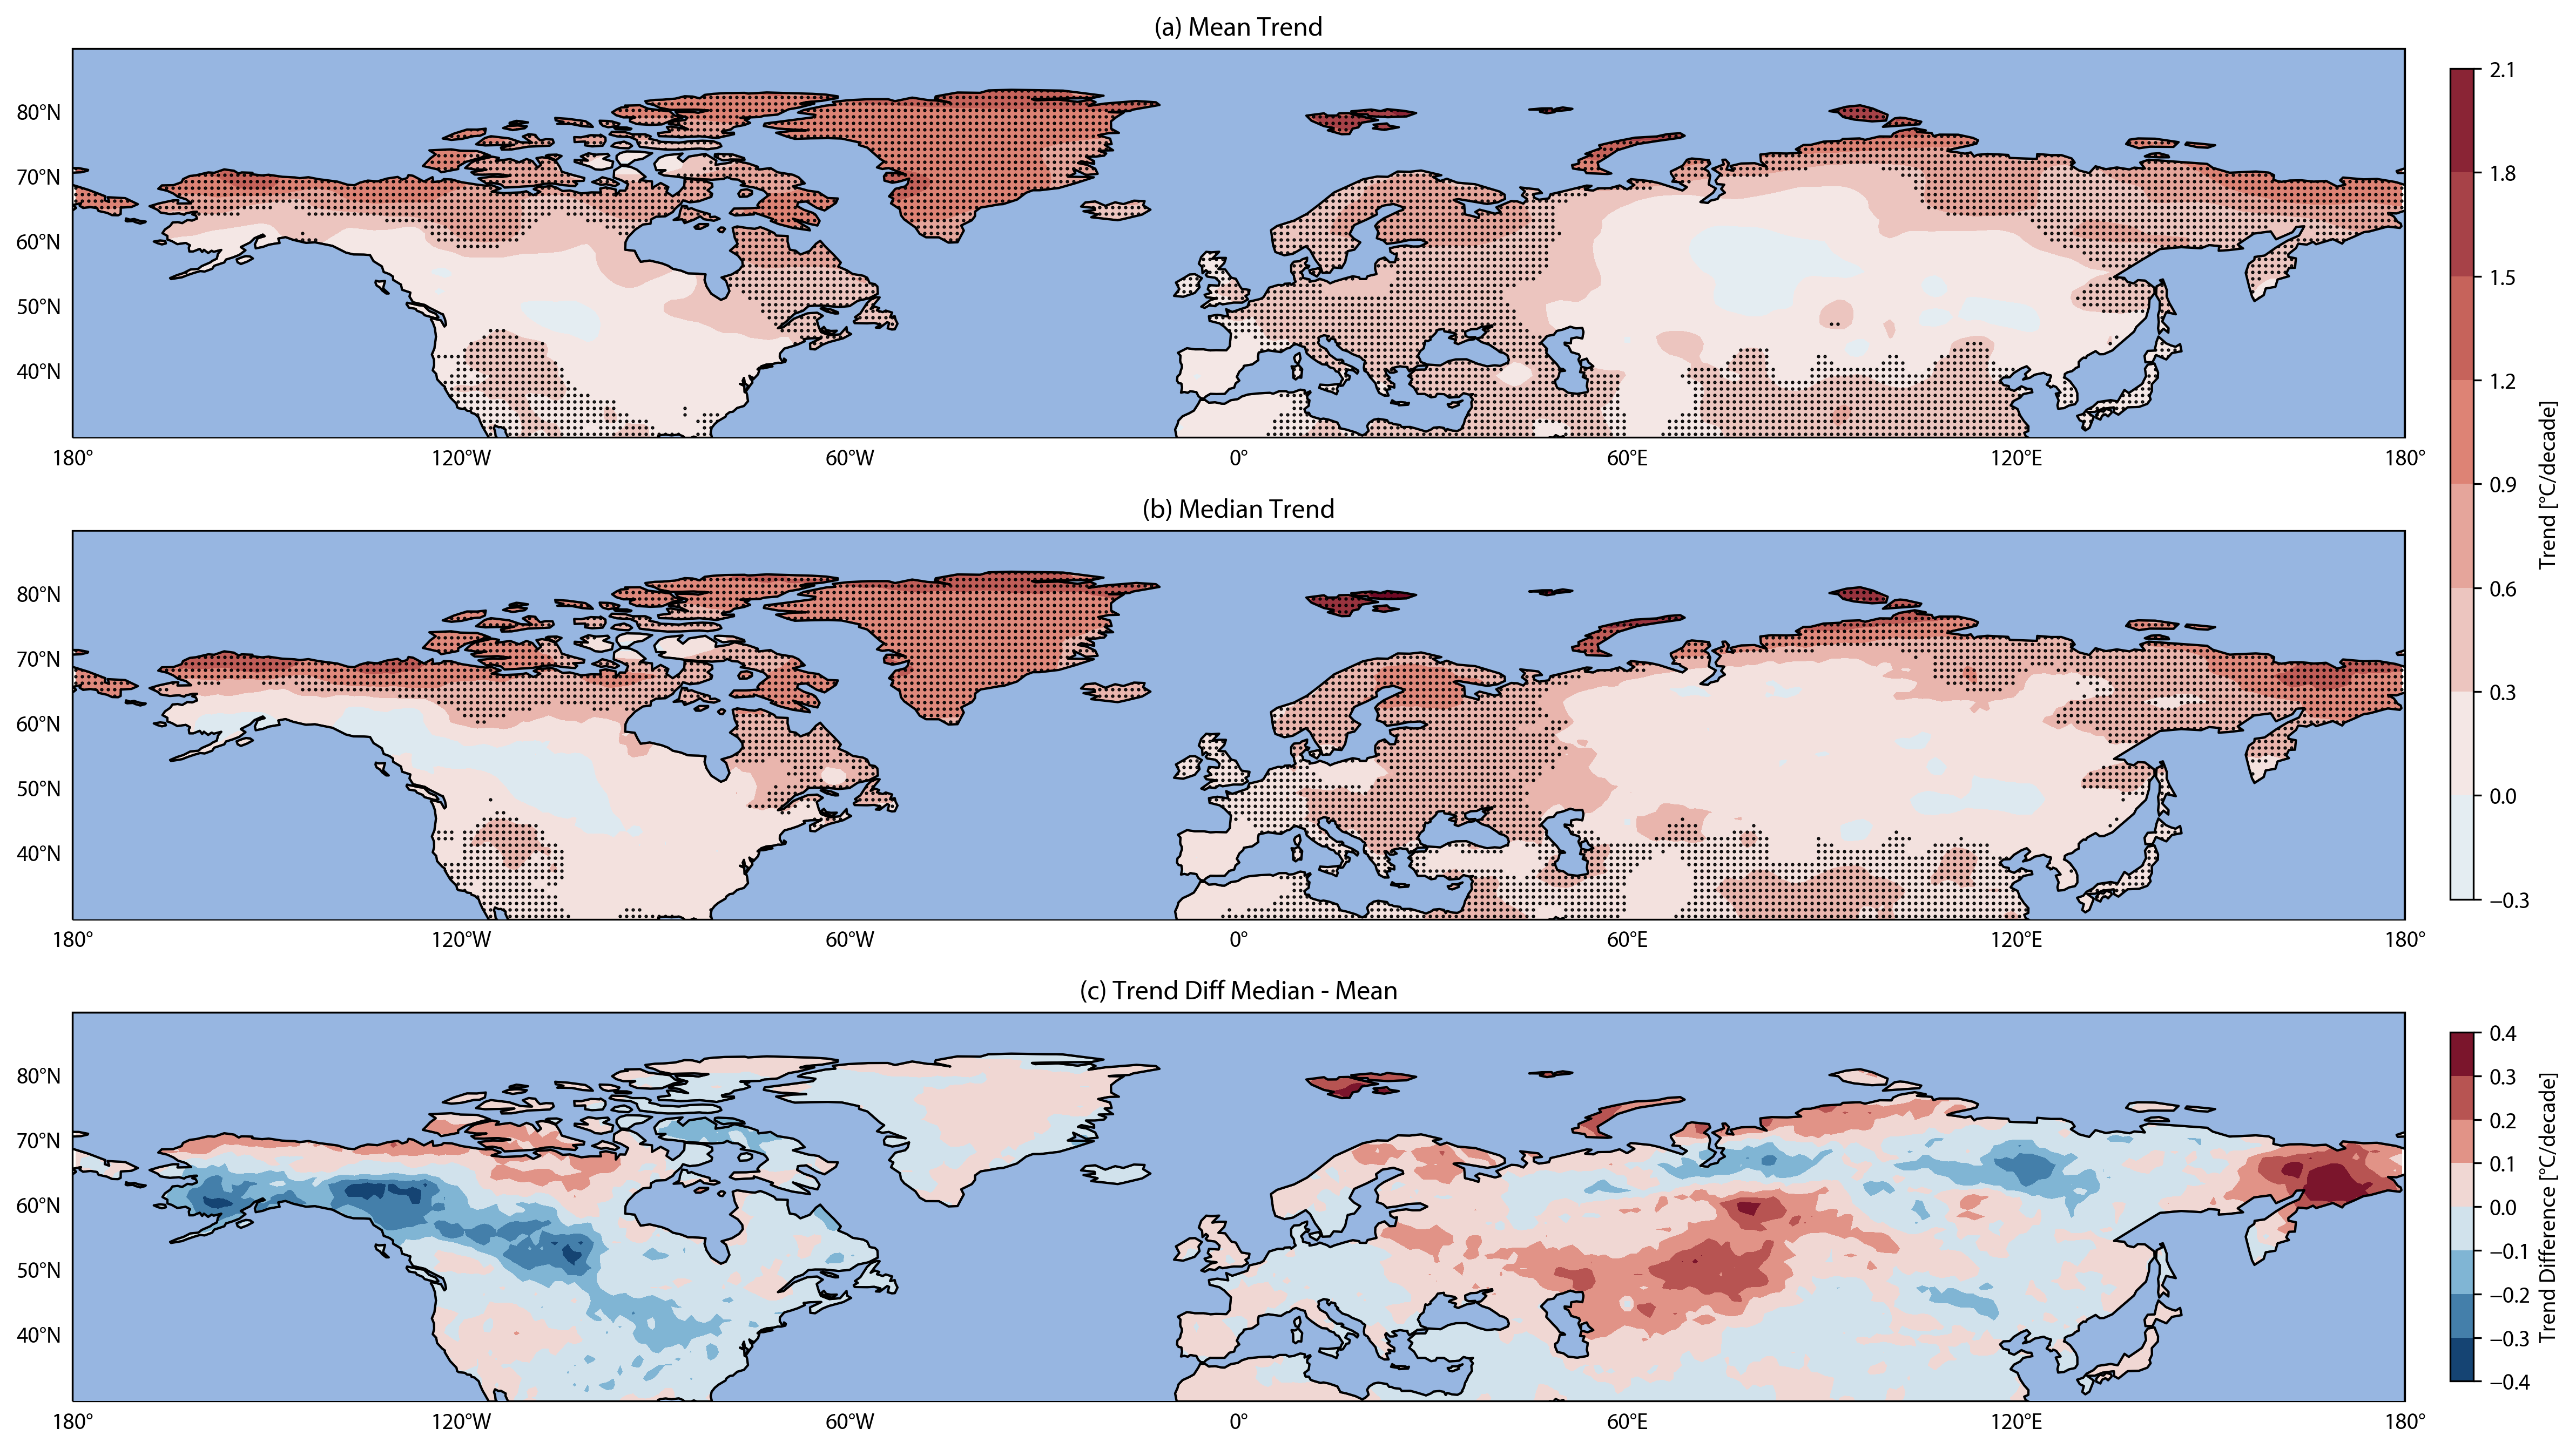

In [28]:
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv_mean[mask == 0] = 1
pv_median[mask == 0] = 1

trend_max = np.max([np.max(k_mean), np.max(k_median)])
trend_min = np.min([np.min(k_mean), np.min(k_median)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = False)

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Mean Trend')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k_mean, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
lons_mean = lons[pv_mean <= 0.1]
lats_mean = lats[pv_mean <= 0.1]
ax0.scatter(lons_mean, lats_mean, color='black', marker='.', s=1)

# Median Trend plot
ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Median Trend')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, k_median, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
lons_median = lons[pv_median <= 0.1]
lats_median = lats[pv_median <= 0.1]
ax1.scatter(lons_median, lats_median, color='black', marker='.', s=1)

# Trend Diff plot
ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend Diff Median - Mean')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
diff_min = np.min(k_median - k_mean)
diff_max = np.max(k_median - k_mean)
diff_norm = MidpointNormalize(vmin=diff_min, vmax=diff_max, midpoint=0)
basemap2 = ax2.contourf(lon, lat, k_median - k_mean, vmin=diff_min, vmax=diff_max, cmap=cmap, norm=diff_norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())

# Shared colorbar for the first two plots
cbar_ax = fig.add_subplot(gs[1:19, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [°C/decade]')

# Independent colorbar for the third plot
cbar_ax2 = fig.add_subplot(gs[21:29, 1])
cbar2 = plt.colorbar(basemap2, cax=cbar_ax2, orientation='vertical')
cbar2.set_label('Trend Difference [°C/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()

In [47]:
pkl_file = open('NH_winter_temp.pkl', 'rb')
# remove the first 90 rows (JFM of 1980) and the last 61 rows (ND of 2020)
temp = pickle.load(pkl_file)[90:-61, :, :]

# thre = 0
days_below_0= np.zeros((39, 90, 360))
days_below_1= np.zeros((39, 90, 360))
days_below_2= np.zeros((39, 90, 360))
for yy in range(39):
    left, right = yy*151, (yy+1)*151
    cnt0 = np.sum((temp[left:right, :, :] < 0), axis=0)
    cnt1 = np.sum((temp[left:right, :, :] < -2.5), axis=0)
    cnt2 = np.sum((temp[left:right, :, :] < -5), axis=0)
    days_below_0[yy, :, :] = cnt0
    days_below_1[yy, :, :] = cnt1
    days_below_2[yy, :, :] = cnt2
    
mask = 1 - np.isnan(np.mean(temp_mean, axis=0))

In [48]:
k0 = np.zeros((90, 360))
k1 = np.zeros((90, 360))
k2 = np.zeros((90, 360))
pv0= np.zeros((90, 360))
pv1 = np.zeros((90, 360))
pv2 = np.zeros((90, 360))

xx = np.arange(39)
xx = sm.add_constant(xx)

cnt = 0
t1 = time() 

for i in range(90):
    for j in range(360):
        if not mask[i, j]:
            continue

        cnt += 1
        if cnt % 1000 == 0:
            print('Processing ', cnt, ' grids. Time taken so far: ', time() - t1)

        lm0 = sm.OLS(days_below_0[:, i, j], xx).fit()
        k0[i, j] = lm0.params[1] * 10 # multiply by 10 to get the trend per decade
        pv0[i, j] = lm0.pvalues[1]
        # print(lm0.summary())
        # pause = 1

        lm1 = sm.OLS(days_below_1[:, i, j], xx).fit()
        k1[i, j] = lm1.params[1] * 10 # multiply by 10 to get the trend per decade
        pv1[i, j] = lm1.pvalues[1]

        lm2 = sm.OLS(days_below_2[:, i, j], xx).fit()
        k2[i, j] = lm2.params[1] * 10 # multiply by 10 to get the trend per decade
        pv2[i, j] = lm2.pvalues[1]




Processing  1000  grids. Time taken so far:  1.4142208099365234
Processing  2000  grids. Time taken so far:  2.549072265625
Processing  3000  grids. Time taken so far:  3.6931021213531494
Processing  4000  grids. Time taken so far:  4.831351280212402
Processing  5000  grids. Time taken so far:  5.9773194789886475
Processing  6000  grids. Time taken so far:  7.121946811676025
Processing  7000  grids. Time taken so far:  8.2643723487854
Processing  8000  grids. Time taken so far:  9.40686845779419
Processing  9000  grids. Time taken so far:  10.545689821243286
Processing  10000  grids. Time taken so far:  11.69094443321228
Processing  11000  grids. Time taken so far:  12.840150833129883
Processing  12000  grids. Time taken so far:  13.98637318611145
Processing  13000  grids. Time taken so far:  15.127303838729858


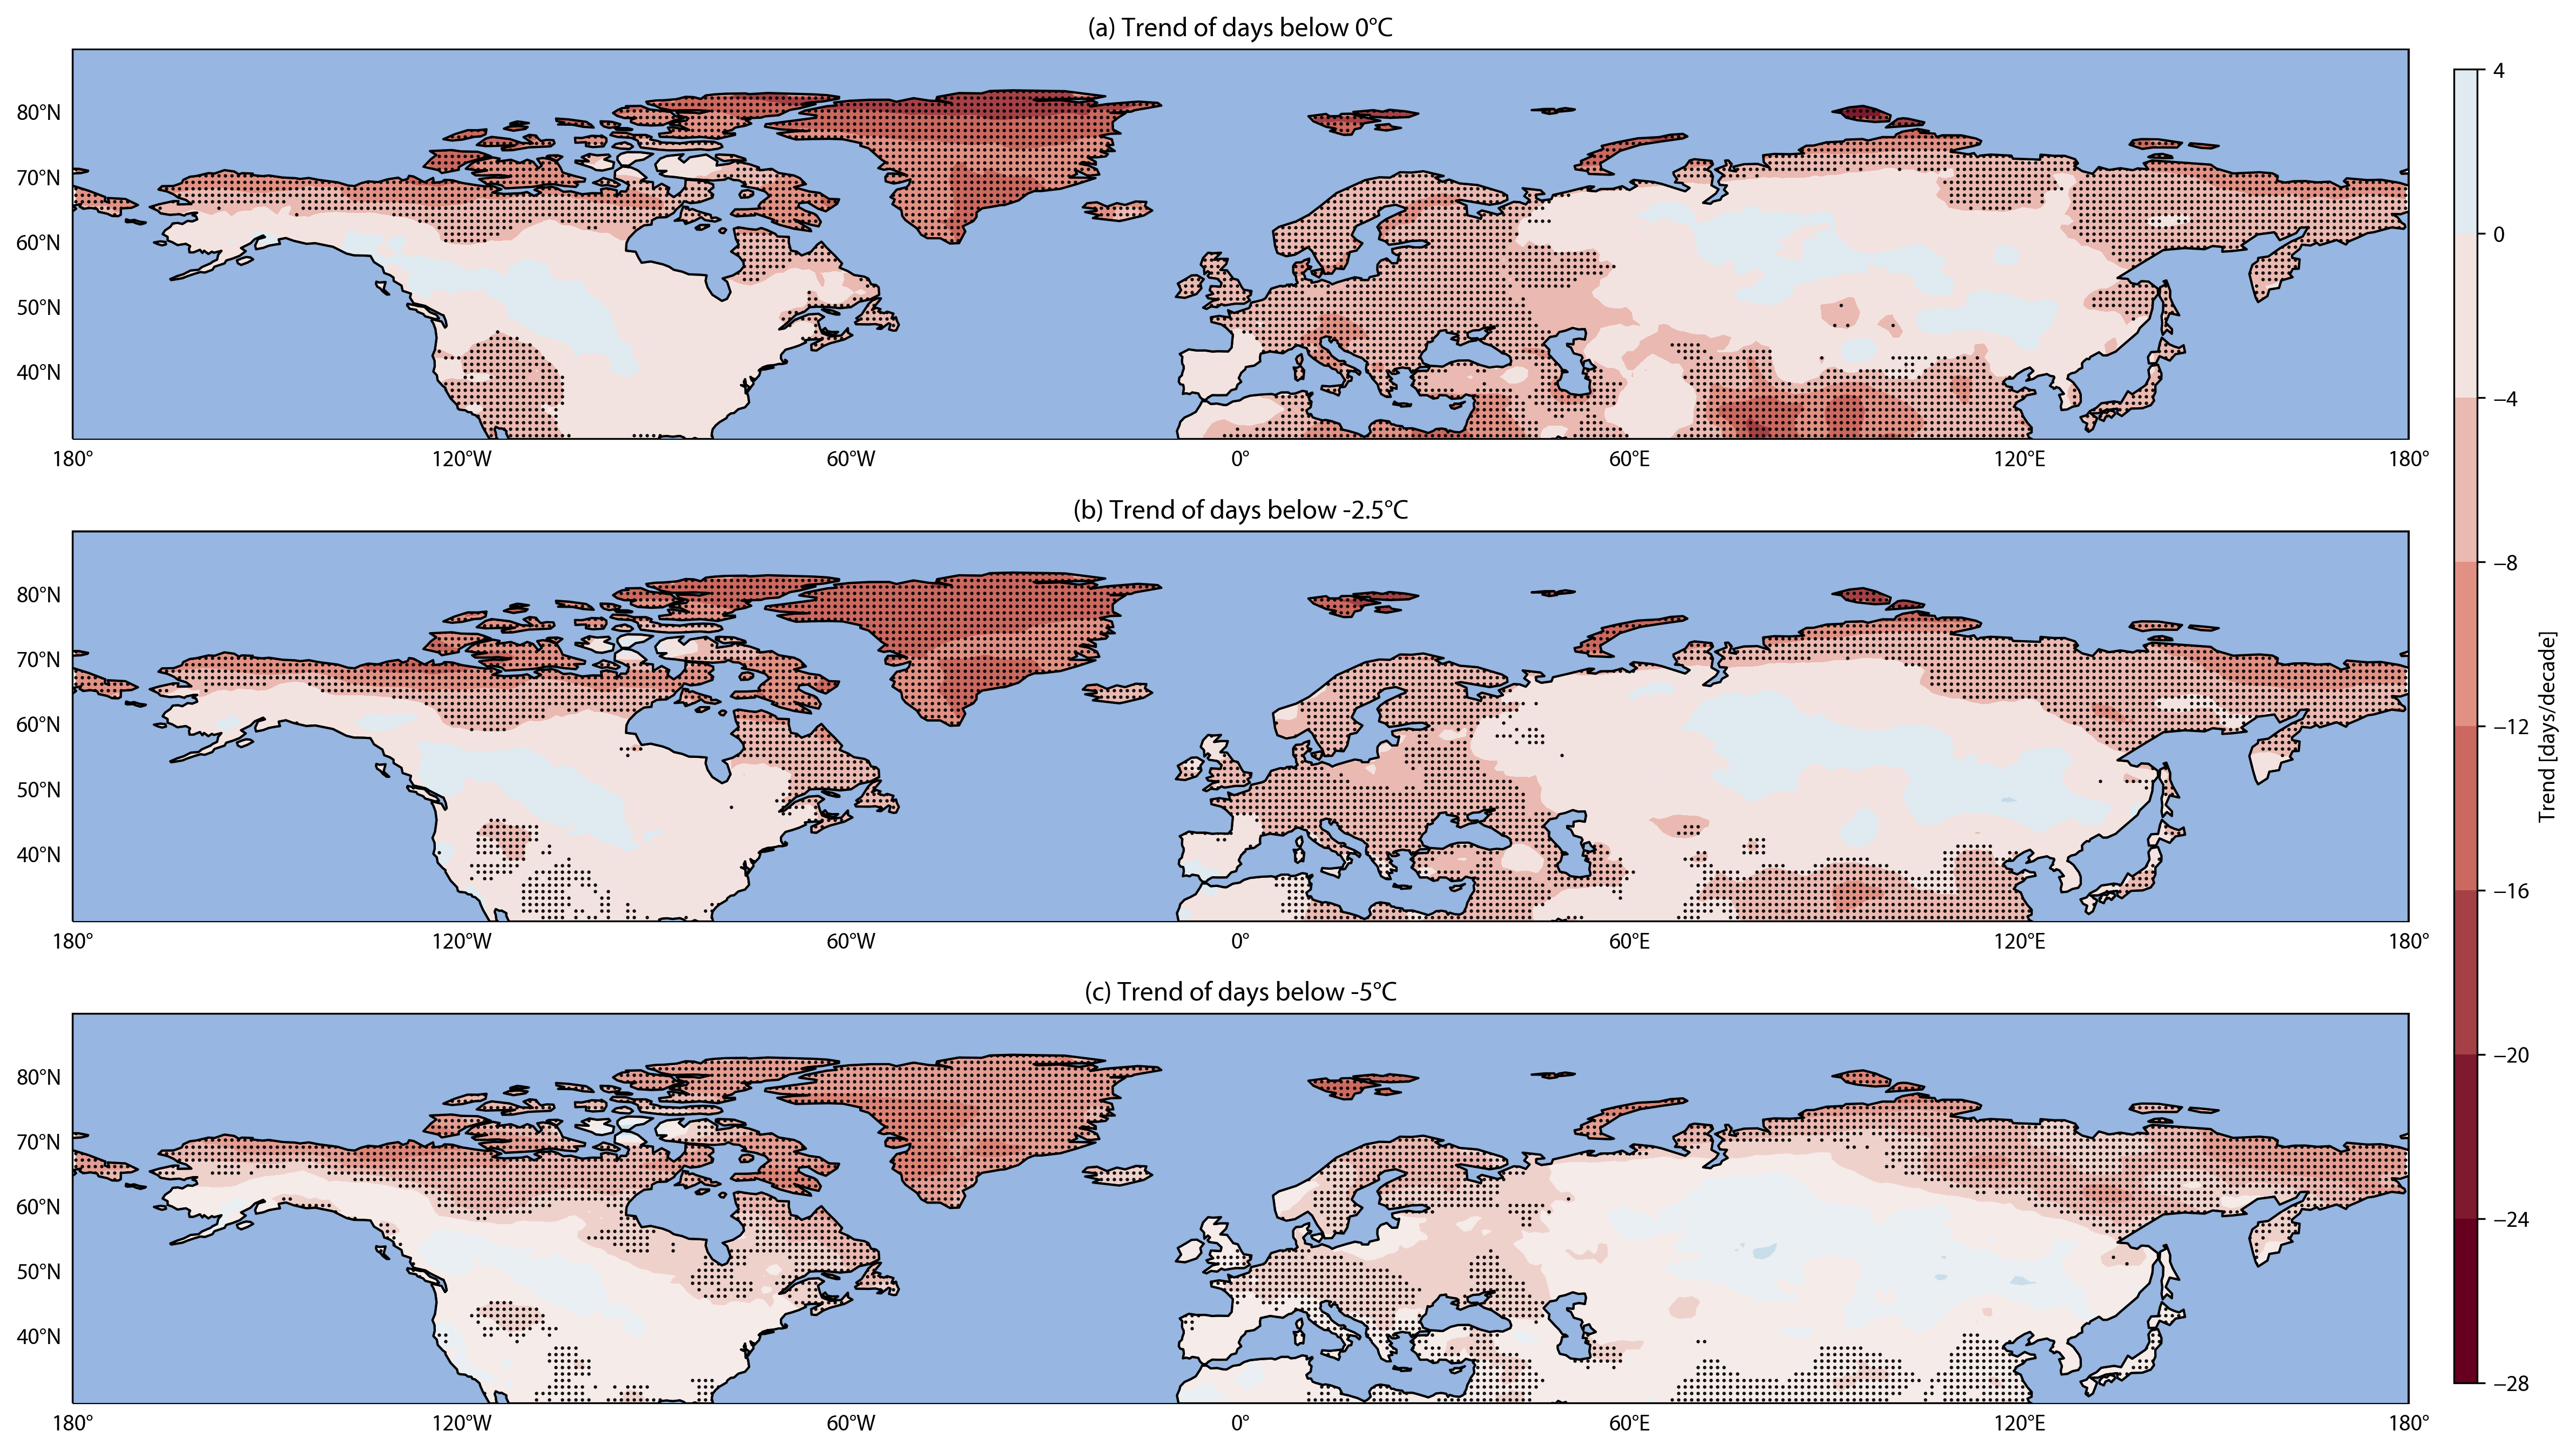

In [49]:
lon = np.linspace(-179.5, 179.5, 360) 
lat = np.linspace(0.5, 89.5, 90)
lons, lats = np.meshgrid(lon, lat)
pv0[mask == 0] = 1
pv1[mask == 0] = 1
pv2[mask == 0] = 1

trend_max = np.max([np.max(k0), np.max(k1), np.max(k2)])
trend_min = np.min([np.min(k0), np.min(k1), np.min(k2)])

norm = MidpointNormalize(vmin=trend_min, vmax=trend_max, midpoint=0)
cmap = cmap_prep.get_ipcc_cmap(type_ = 'div', var_ = 'temp', levels = 5, reverse = True)

fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(30, 2, width_ratios=[20, 0.2])

# Mean Trend plot
ax0 = fig.add_subplot(gs[0:10, 0], projection=ccrs.PlateCarree())
ax0.set_title('(a) Trend of days below 0°C')
ax0.coastlines()
ax0.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap0 = ax0.contourf(lon, lat, k0, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax0.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
lons0 = lons[pv0 <= 0.1]
lats0 = lats[pv0 <= 0.1]
ax0.scatter(lons0, lats0, color='black', marker='.', s=1)

ax1 = fig.add_subplot(gs[10:20, 0], projection=ccrs.PlateCarree())
ax1.set_title('(b) Trend of days below -2.5°C')
ax1.coastlines()
ax1.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap1 = ax1.contourf(lon, lat, k1, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
lons1 = lons[pv1 <= 0.1]
lats1 = lats[pv1 <= 0.1]
ax1.scatter(lons1, lats1, color='black', marker='.', s=1)

ax2 = fig.add_subplot(gs[20:30, 0], projection=ccrs.PlateCarree())
ax2.set_title('(c) Trend of days below -5°C')
ax2.coastlines()
ax2.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k')
basemap2 = ax2.contourf(lon, lat, k2, vmin=trend_min, vmax=trend_max, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
ax2.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree())
lons2 = lons[pv2 <= 0.1]
lats2 = lats[pv2 <= 0.1]
ax2.scatter(lons2, lats2, color='black', marker='.', s=1)

cbar_ax = fig.add_subplot(gs[1:29, 1])
cbar = plt.colorbar(basemap0, cax=cbar_ax, orientation='vertical')
cbar.set_label('Trend [days/decade]')

for i in range(3):
    gl = [ax0, ax1, ax2][i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()